# Détectez des faux billets avec R ou Python

# Sommaire

* [Introduction : Première analyse & données manquantes](#introduction)

* [1) Détermination du modèle de régression pour les valeures manquantes et analyse des données](#partie1)
     * [a) Evaluation du modèle de régression linéaire multiple](#section_1_1)
     * [b) Tests sur la régression linéaire multiple](#section_1_2)
     * [c) Analyse descriptive des billets ](#section_1_3)
     * [d) Portraits robots des billets](#section_1_4)

* [2) Modèles de reconnaissance des billets](#partie2)
     * [a) Méthode KMEAN](#section_2_1)
     * [b) Méthode Régression logistique](#section_2_2)
     * [c) Méthode KNN](#section_2_3)
     
* [Conclusion générale](#conclusion)

* [Evaluation :  algorithme généralisé pour le modèle "régression logistique"](#evaluation)
    

In [1]:
# Bibliothèques classiques pour traitement et présentation du projet
import numpy as np
import pandas as pd
import scipy as st
from scipy.stats import t, shapiro
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliothèques des méthodes utiles sklearn
from sklearn import decomposition, preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, metrics
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import neighbors

# Pour statsmodel
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white , normal_ad
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM

# sauvegarde du modèle
import pickle

# Introduction : Première analyse & données manquantes<a class="anchor" id="introduction"></a>

In [2]:
# Je récupère les données du projet ==> je m'aperçoit qu'il y a un problème avec la présentation des données (tout est sur une même ligne)
# ==> utilsation d'un sépararteur afin d'afficher correctement les données
billets = pd.read_csv("billets.csv", sep=';')
billets.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
5,True,172.17,103.74,104.08,4.42,2.95,112.81
6,True,172.34,104.18,103.85,4.58,3.26,112.81
7,True,171.88,103.76,104.08,3.98,2.92,113.08
8,True,172.47,103.92,103.67,4.00,3.25,112.85
9,True,172.47,104.07,104.02,4.04,3.25,113.45


In [3]:
# J'étudie les données
billets.shape

(1500, 7)

In [4]:
# ==> 1500 individus (billets) pour 7 variables. Je récupère plus d'informations
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [5]:
# ==> Sur les 7 variables : 1 variable qualitative (billet "vrai" ou "faux") et 6 quantitatives (6 longueures concernant le billet)
# Je m'aperçoit qu'il manque des valeures pour la variable "margin_low" ==> utilisation de la régression linéaire multiple afin d'optenir les valeures manquantes
# Je commence par retirer les billets ou il manque des informations
donnees_manquantes = billets[billets["margin_low"].isna() == True]
billets.drop(donnees_manquantes.index, inplace=True) 
billets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


In [6]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000
mean,171.959193,104.031333,103.921476,4.485967,3.153083,112.674757
std,0.305457,0.299605,0.324181,0.663813,0.231466,0.873222
min,171.040000,103.140000,102.910000,2.980000,2.270000,109.490000
25%,171.750000,103.825000,103.710000,4.015000,2.990000,112.020000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.960000
75%,172.170000,104.230000,104.150000,4.870000,3.315000,113.340000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.320000


Nous avons des valeures margin_low comprisent entre 2.98 et 6.9

# 1) Détermination du modèle de régression pour les valeures manquantes et analyse des données<a class="anchor" id="partie1"></a>

In [7]:
# Les données manquantes ont été retirées ==> création du modèle de régression linéaire multiple afin d'extrapoler les valeures manquantes
reg_lin_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=billets).fit()
print(reg_lin_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 06 Oct 2023   Prob (F-statistic):          2.60e-202
Time:                        15:55:47   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

## a) Evaluation du modèle de régression linéaire multiple<a class="anchor" id="section_1_1"></a>

**Le R² ajusté est égal à 0.47**,c’est le pourcentage de variation de la variable dépendante qui est expliqué par un modèle linéaire corrigé par le nombre de degrè de liberté. Mais il ne permet pas de savoir si le modèle est statistiquement significatif, c'est ici qu'intervient le test de significativité glogale de Fisher.

**Test de significativité globale**

La formulation du test d'hypothèse qui permet d'évaluer globalement le modèle est la suivante :

H0 : a1 = a2 = … = ap = 0 ;
H1 : un des coefficients au moins est non nul.

Rejet de H0 si et seulement si Fcalc > F1 - α(p, n - p - 1), où α est le risque de première espèce. autrement dit, si la p-value du test de fisher (Prob(F-statistic)) avec  est inférieure à α (=0.05)  , l'hypothèse nulle est rejetée.

**Prob(F-Statistic):**  Ici, elle est très faible et inférieure au seuil alpha 5 % (2.60*10^-202), on rejet l'hypothèse nulle, **notre modèle est significatif.**

***Significativité des coefficients: test de student***: 
Les probabilités de toutes les variables explicatives sont inférieure à 0.05, **ces variables sont statistiquement significatives dans le modèle**

## b) Tests sur la régression linéaire multiple<a class="anchor" id="section_1_2"></a>

**Normalité de la distribution des résidus** :  l'hypothèse nulle est que les résidus sont distribués selon une loi Normale. La valeur de Prob(Omnibus) doit être proche de 1. Ici elle est nulle ce qui implique que l'hypothèse n'est pas verifée, les coefficiants estimés ne seront pas BLUE. Prob(Jacque-Bera) est redondant avec Prob(Omnibus), une valeur élevée pour le Jarque-Bera indique que les résidus sont distribués selon une loi Normale. Pour lever le doute on effectue un test d'Aderson-Darling.


La p-value du test d'Aderson-Darling vaux (4.855027246396503, 5.114137678797947e-12)


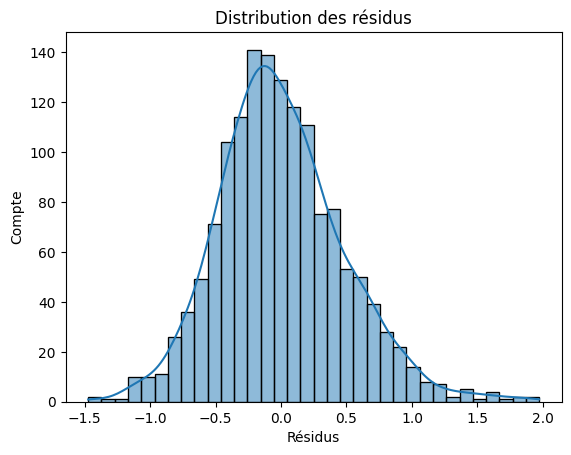

In [8]:
# Calcul des residus:
residus = reg_lin_multi.resid

# Test de normalité:
print("La p-value du test d'Aderson-Darling vaux", normal_ad(residus))

# Visualisation graphique:
sns.histplot(residus, kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

**Le test d'Aderson-Darling et le graphique de la distribution des résidus montrent que les résidus suivent une loi normale ==> hypothèse de normalité vérifiée**

**Homocédasticité** : les variances des résidus doivent être constantes. Les tests de Breusch-Pagan et de White permettent de tester l'hypothèse d'homoscédasticité du terme d'erreur d'un modèle de régression linéaire. Le test de Breusch-Pagan ne fonctionne pas très bien pour les distributions non-normales et non-linéaires contrairement au test de White qui est en fait un cas particulier du Breusch-Pagan.

In [9]:
# Je commence par calculer la moyenne des résidus
residus.describe()

count    1.463000e+03
mean    -1.727255e-13
std      4.799064e-01
min     -1.472342e+00
25%     -3.170738e-01
50%     -4.168097e-02
75%      2.735290e-01
max      1.970836e+00
dtype: float64

**La moyenne des résidus est très proche de 0**

Je regarde la répartition de ces valeures et détermine la p-value des tests de White et Breusch-Pagan

{'Test Statistic': 109.8601519688568, 'p-value': 2.082824498809048e-14, 'F-Statistic': 5.853731207812509, 'F-Test p-value': 4.97486509226491e-15}
{'Test Statistic': 80.16261280177379, 'p-value': 7.759535216108084e-16, 'F-Statistic': 16.892358846158672, 'F-Test p-value': 2.922749656586908e-16}


Text(0.5, 1.0, 'Homoscédasticité')

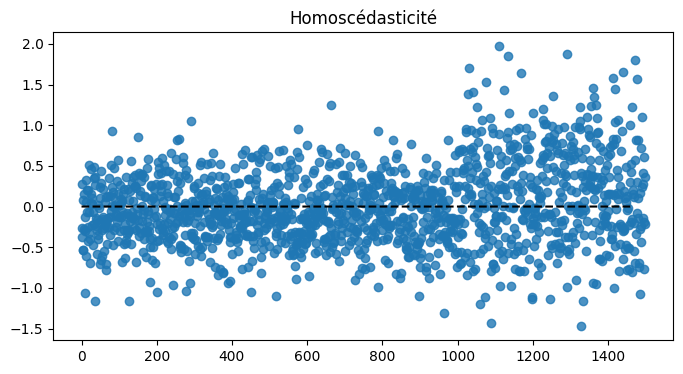

In [10]:
# Test de White:
white_test = het_white(reg_lin_multi.resid, reg_lin_multi.model.exog)
labels_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_test, white_test)))

# Test de Breusch-Pagan
test_breush_pagan = sms.het_breuschpagan(reg_lin_multi.resid, reg_lin_multi.model.exog)
print(dict(zip(labels_test, test_breush_pagan)))

# Graphique de l'homocédasticité:
plt.subplots(figsize=(8, 4))
plt.scatter(x=billets.index, y=residus, alpha=0.8)
plt.plot(np.repeat(0, len(billets.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

**L'hypothèse d'homocédasticité est validée**

**Non-autocorrélation** : l'autocorrélation est la corrélation des erreurs (résidus) dans le temps.

H0: non auto-correlation

H1: auto-correlation

La statistique Durbin-Watson prend ses valeurs entre 0 (auto-corrélation linéaire positive) et 4 (auto-corrélation linéaire négative). L'hypothèse nulle est retenue si la statistique a une valeur proche de 2 (pas d'auto-corrélation linéaire) 

**Ici, il est de 1.893, nous sommes proche de 2 ==> H0 retenu ==> Pas d'auto-correlation.**

**Multicollinéarité** : on suppose que les prédicteurs utilisés dans la régression ne sont pas corrélés les uns aux autres. Le cond. No. est élevée il semble qu'il y ai un problème de multicollinéarité.

Je vais déterminer le "VIF"(Variance Inflation Factor) de chaque variable.

In [11]:
# Je récupère les données des variables dont je calculerai le VIF
X = billets[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
  
# Création de mon tableau VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# je récupère toutes les données du tableau "results"
variables = reg_lin_multi.model.exog
    
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(variables, i)
                          for i in range(1,variables.shape[1])]

# Affichage de mon tableau
vif_data

,feature,VIF
0,diagonal,1.013613
1,height_left,1.138261
2,height_right,1.230115
3,margin_up,1.404404
4,length,1.576950


**Les VIF de mes variables sont toutes proches de 1 ==> Pas de problème de multicolinéarité**

**Linéarité** : on fait l'hypothèse qu'il existe une relation linéaire entre les variables indépendantes et la variable dépendante.

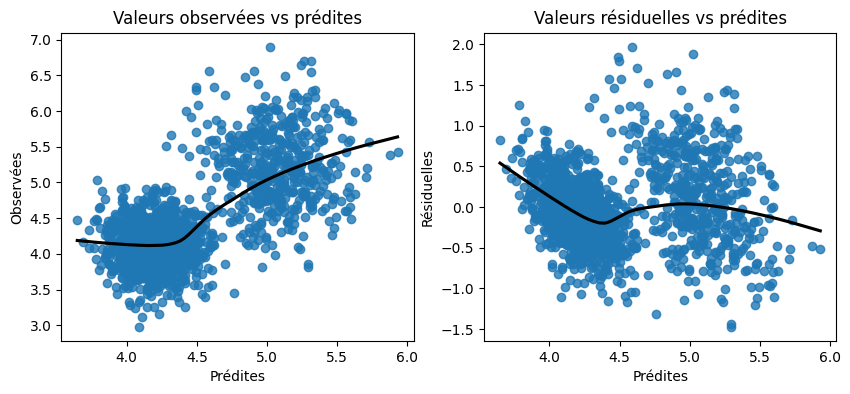

In [12]:
# Fonction permettant de tester la linéarité d'un modèle
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'black'})
    ax[0].set_title("Valeurs observées vs prédites")
    ax[0].set(xlabel="Prédites", ylabel="Observées")

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'black'})
    ax[1].set_title("Valeurs résiduelles vs prédites")
    ax[1].set(xlabel="Prédites", ylabel="Résiduelles")
    
linearity_test(reg_lin_multi, billets["margin_low"])

**La relation n'est pas linéaire, l'hypothèse de linéarité n'est pas vérifiée.**

#### Conclusion : le modèle choisi est bon (régression linéaire multiple) ==> Nous allons pouvoir déterminer les valeures manquantes précedentes

In [13]:
X = donnees_manquantes.drop(columns=['is_genuine','margin_low'], axis=1)

# Prédiction des valeurs manquantes avec le modèle de régression linéaire multiple
margin_low_score=pd.Series(reg_lin_multi.predict(X))

# Optention du tableau_final
margin_low_result= pd.concat([donnees_manquantes, margin_low_score], axis=1)
margin_low_result_2 = margin_low_result.drop(columns=['margin_low'], axis=1)
margin_low_result_2.rename(columns={0: 'margin_low'}, inplace=True)

reg_result = [billets, margin_low_result_2]
Billet_vf = pd.concat(reg_result)
Billet_vf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


## c) Analyse descriptive des billets <a class="anchor" id="section_1_3"></a>

### La matrice des corrélations

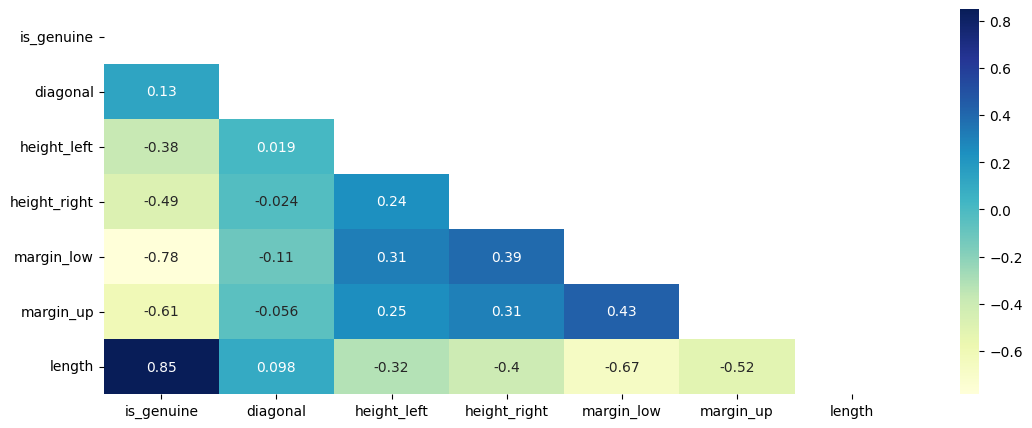

In [14]:
matrix = Billet_vf.corr()
# Triangle de corrélations
mask = np.triu(np.ones_like(matrix))
plt.figure(figsize=(13, 5))
dataplot = sns.heatmap(matrix, cmap="YlGnBu", annot=True, mask=mask)
plt.show()

la variable qui nous intéresse le plus est **"is_genuine"**

***Elle est fortement corrélée avec la variable "length" et inversement corrélée avec la variable "margin_low"***

### Nombre et pourcentage de vrais/faux billets

In [15]:
# Nombre de vrais / faux billets
faux_billets= Billet_vf.loc[Billet_vf['is_genuine'] ==False]
vrai_billets= Billet_vf.loc[Billet_vf['is_genuine'] ==True]
print(vrai_billets.shape,faux_billets.shape)

(1000, 7) (500, 7)


**Il y a 1000 vrais billets et 500 faux billets**

<AxesSubplot: ylabel='is_genuine'>

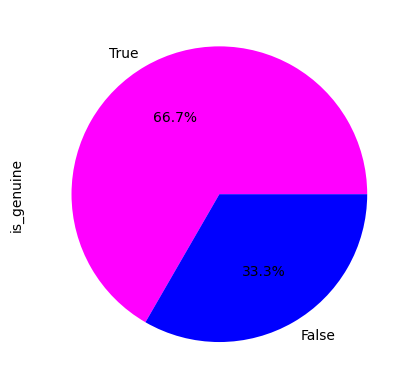

In [16]:
# Pourcentage représenté avec un camembert
colors = ( "magenta", "blue")
Billet_vf["is_genuine"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors )

### Scatter plot entre chaque variable

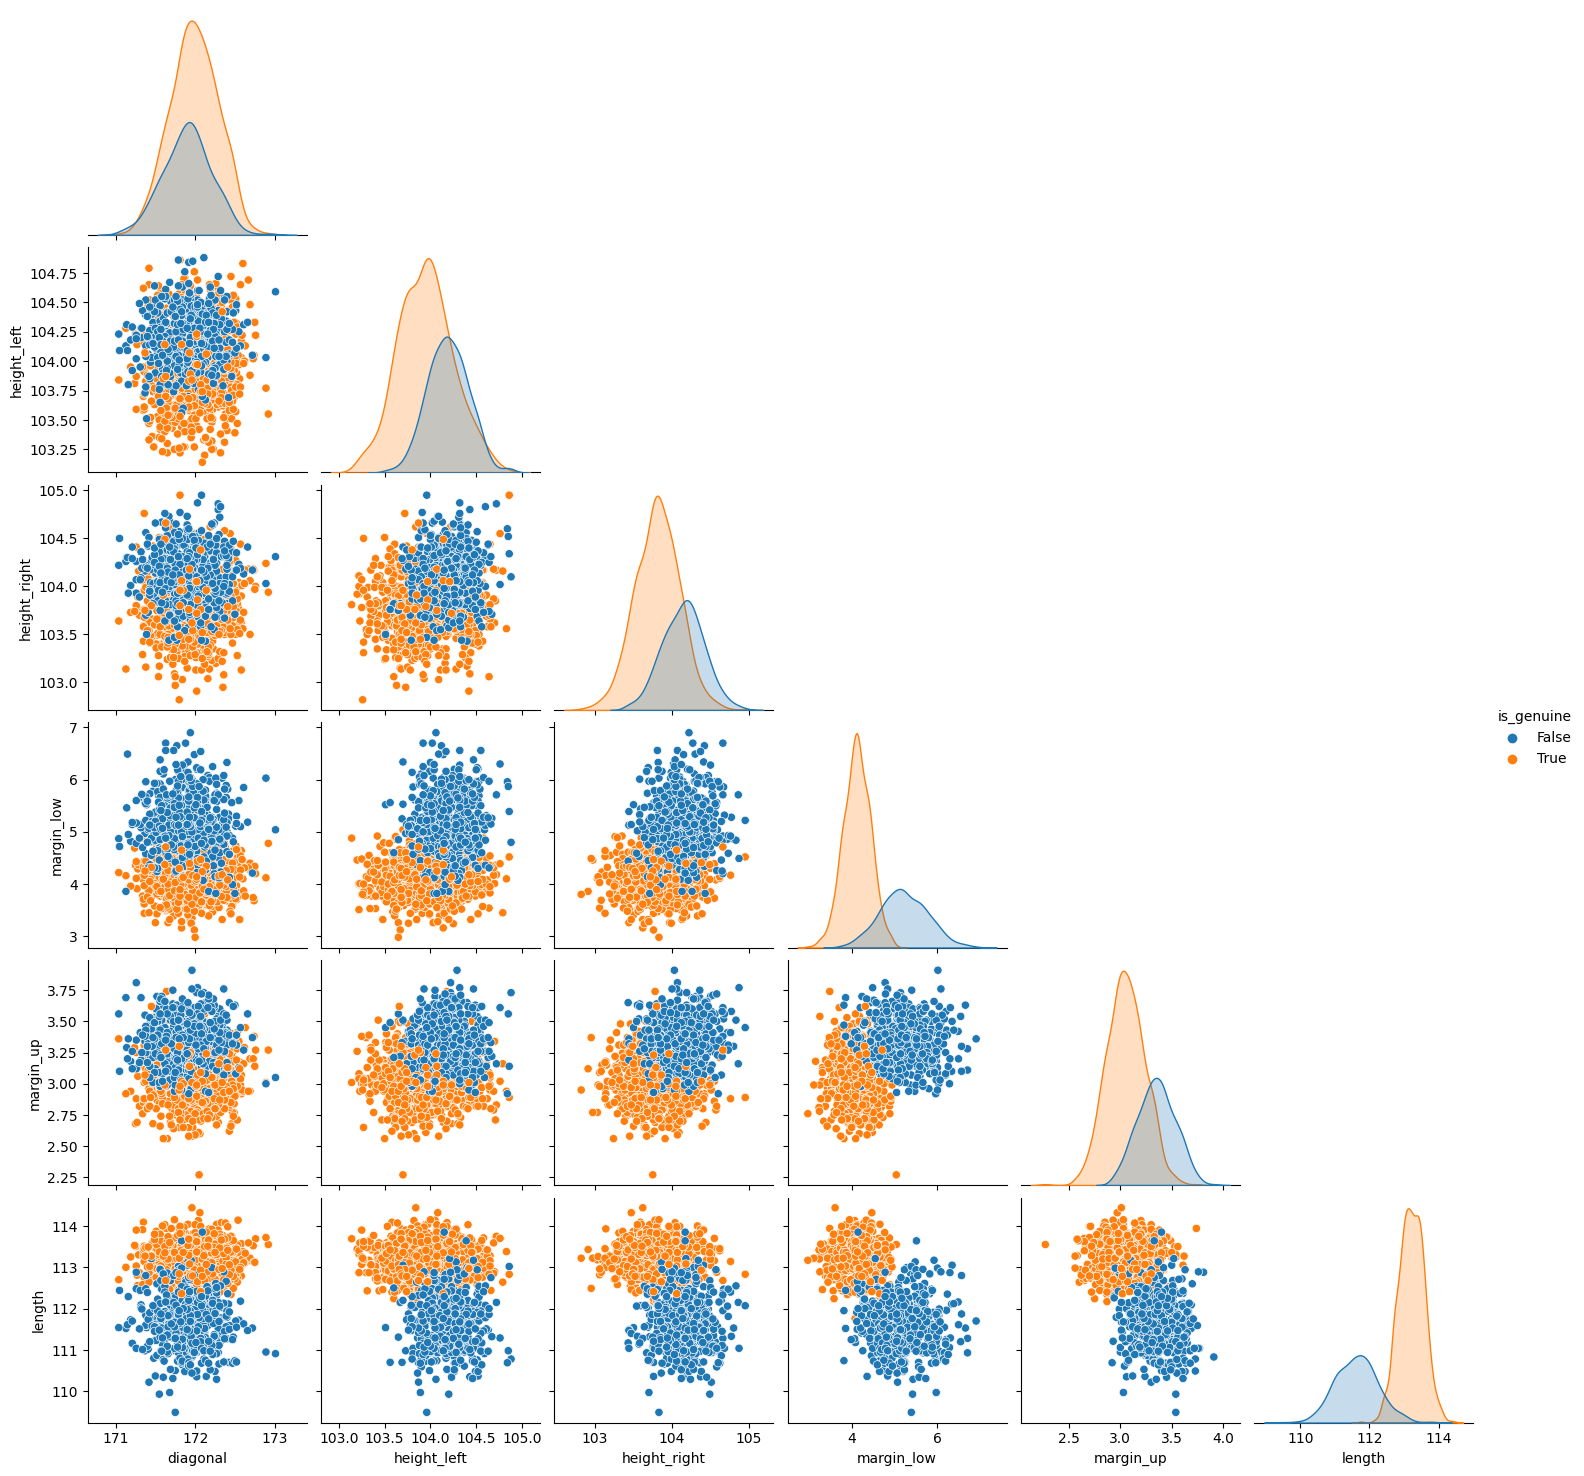

In [17]:
sns.pairplot(Billet_vf, hue="is_genuine", corner=True)

**Les représentations les plus intéressantes sont entre "margin_low" et "length" ainsi que "margin_low" et "margin_up"**

### Distribution des valeures, moyenne et médiane de chaque variables

Diagonal


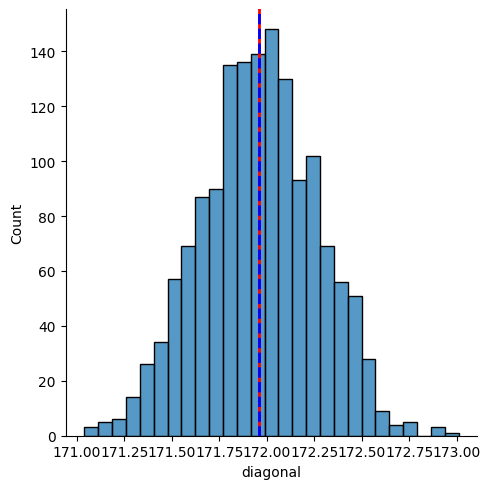

KstestResult(statistic=0.029666666666666668, pvalue=0.6586292316713649, statistic_location=171.86950850402707, statistic_sign=-1)
Height_left


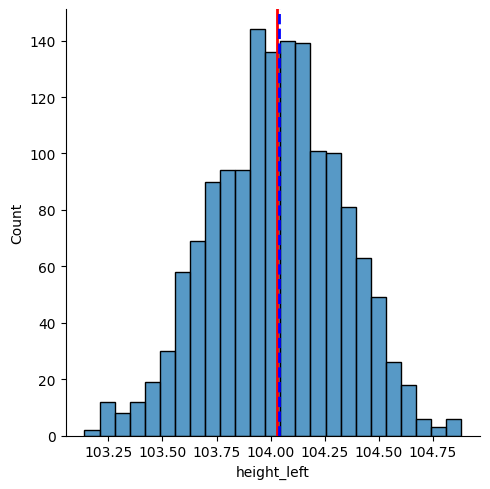

KstestResult(statistic=0.031, pvalue=0.6036491108686072, statistic_location=104.02987997034008, statistic_sign=-1)
Height_right


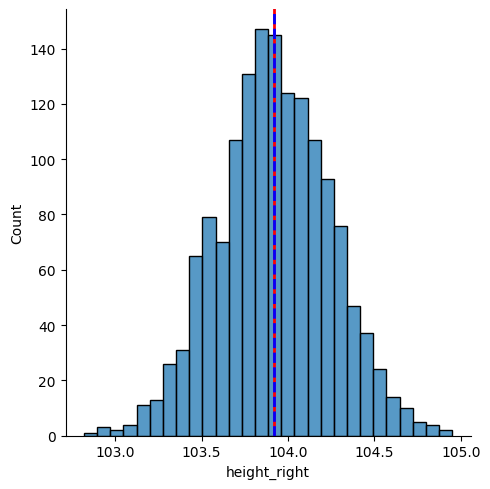

KstestResult(statistic=0.03333333333333333, pvalue=0.5101134773185192, statistic_location=103.94, statistic_sign=1)
Margin_low


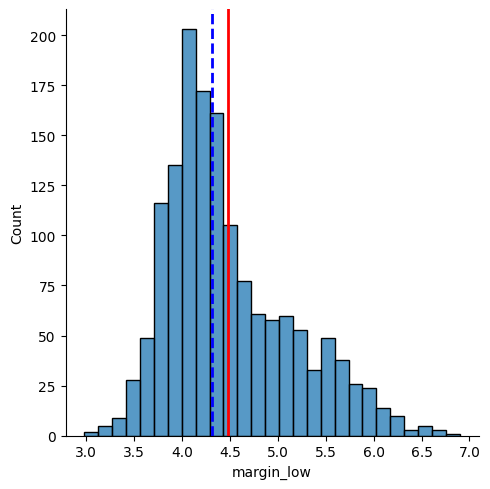

KstestResult(statistic=0.11566666666666667, pvalue=1.9591564464174225e-07, statistic_location=4.49, statistic_sign=1)
Margin_up


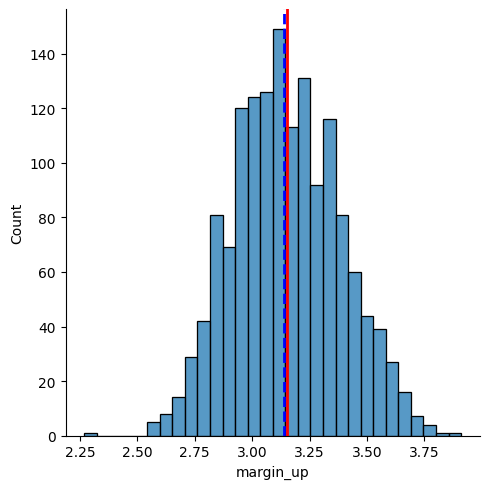

KstestResult(statistic=0.046, pvalue=0.15443621836594554, statistic_location=3.14, statistic_sign=1)
Length


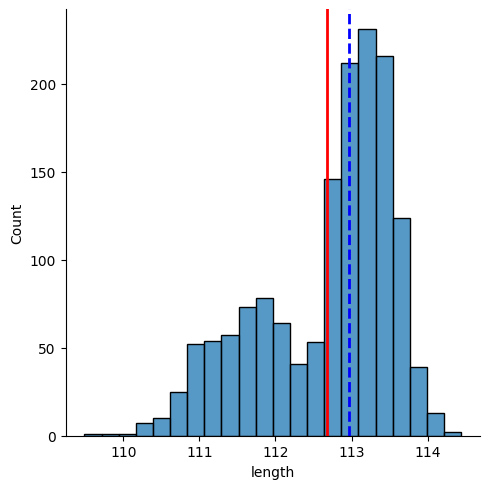

KstestResult(statistic=0.15833333333333333, pvalue=1.422869292985965e-13, statistic_location=112.88985495844695, statistic_sign=-1)


In [18]:
def distrib_normalize(i):
  
  print(i.capitalize())
  _ = sns.displot(Billet_vf[i])
  _ = plt.axvline(x=Billet_vf[i].mean(), label='Moyenne', linestyle='-', color='r', linewidth=2)
  _ = plt.axvline(x=Billet_vf[i].median(), label='Médiane', linestyle='--', color='b', linewidth=2)
  _ = plt.show()
  
  print(str(ks_2samp(Billet_vf[i],list(np.random.normal(np.mean(Billet_vf[i]), np.std(Billet_vf[i]), 1000)))))

cols = Billet_vf[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

for i in cols:
    distrib_normalize(i)

**Toutes les variables suivent une distribution normalisée**

### Description générale

In [19]:
Billet_vf.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483475,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659632,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


## d) Portraits robots des billets<a class="anchor" id="section_1_4"></a>

In [20]:
vrai_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.118174,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.317575,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.910000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.120000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [21]:
faux_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.214079,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.550363,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.180000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.590000,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


***Portrait-robot du vrai billet*** :

Hauteur mesurée à gauche : 103.95 mm

Hauteur mesurée à droite : 103.80 mm

Marge inférieure : 4.11 mm

Marge supérieure : 3.05mm

Longueur : 111.20 mm

Diagonale : 171.98 mm

**Portrait-robot du faux billet :**

Hauteur mesurée à gauche : 103.94 mm

Hauteur mesurée à droite : 103.80 mm

Marge inférieure : 5.21 mm

Marge supérieure : 3.35mm

Longueur : 111.63 mm

Diagonale : 171.90 mm

#### Vérifions si les  différences de moyennes des caractéristiques de nos billets sont significatives

Test de Student

H0: Les moyennes des vrais billets et celles des faux billets sont égales

H1: Les moyennes ne sont pas égales.

In [22]:
# Variable quantitative
x =( "diagonal","height_left","height_right","margin_low","margin_up","length")
# Variable qualitative
y = "is_genuine"
for i in x:
    samplei = Billet_vf[i][Billet_vf[y]]
    sample1 = Billet_vf[i][~Billet_vf[y]]

    t_stat, pvalue = ttest_ind(samplei, sample1)
    print("T-stat = {}, p-value = {}".format(
        round(t_stat, 2),
        round(pvalue, 2)))
    if pvalue < 0.05:
        print("On rejette H0.\nLes vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= {} à un niveau de confiance de 95%.".format(i))
       
    else:
        print("On ne rejette pas H0: Les moyennes sont identiques pour la variable x= {} à un niveau de confiance de 95%.".format(i))

T-stat = 5.18, p-value = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= diagonal à un niveau de confiance de 95%.
T-stat = -15.89, p-value = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= height_left à un niveau de confiance de 95%.
T-stat = -21.47, p-value = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= height_right à un niveau de confiance de 95%.
T-stat = -48.79, p-value = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= margin_low à un niveau de confiance de 95%.
T-stat = -29.51, p-value = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= margin_up à un niveau de confiance de 95%.
T-stat = 62.26, p-value = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la var

**Les vrais et faux billets n'ont pas les mêmes moyennes**

**Nos différents modèles vont nécessités des données tests et préparations, elles seront communes à tous nos modèles afin de pouvoir, plus tard, les comparer proprements**

In [23]:
col1 = ["diagonal","height_left","height_right","margin_low","margin_up","length"]
col2 = ["is_genuine"]
X = Billet_vf[col1]
Y = Billet_vf[col2]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1) 

# 2) Modèles de reconnaissance des billets<a class="anchor" id="partie2"></a>

## a) Méthode KMEAN<a class="anchor" id="section_2_1"></a>

**Le K-Means** est un algorithme d’apprentissage non supervisé utilisé pour résoudre les problèmes de clustering. Il consiste à classer un ensemble de données dans un nombre de clusters, défini par la lettre « k« , qui est fixé au préalable.On considère la distance d'un point à la moyenne des points de son cluster ; la fonction à minimiser est la somme des carrés de ces distances. il permet de regrouper des individus ou objets ayant les caractéristiques les plus proches au sein de K groupes. Ces groupes (clusters) sont constitués par itération successive de leur centre de gravité jusqu'à ce que les centres de gravité soient parfaitement équilibrés. C'est ce que l'on appelle la convergence de l'algorithme.

Dans ce projet, nous allons diviser nos données en deux groupes que nous allons analyser pour voir s'ils correspondent à la nature **vraie** ou **fausse** du billet. Nous projecterons les groupes obtenus dans le premier plan factoriel obtenu par la méthode d'analyse en composantes principales.

**l'ACP** va nous permettre de reduire le noimbre de variable en identifiant les liens entre variables et visualiser les résultats du K-means dans un espace à 2 dimensions

### Détermination Eboulis des valeurs propres + axes principaux + Plan factoriel

In [24]:
cols = ["diagonal","height_left", "height_right", "margin_low", "margin_up","length"]
Billet_vf_acp = Billet_vf[cols]

## X= matrice des données
X = Billet_vf_acp.values

## La liste des billets
liste_billet = Billet_vf_acp.index

## les noms des colonnes
noms_colonnes = Billet_vf_acp.columns

## je scale les données
scaler = StandardScaler()
scaler.fit(X)

## je centre / réduit les données
X_scaled = scaler.transform(X)

## je travail avec 6 composantes principales
n_components = 6

## j'instancie l'ACP
acp = PCA(n_components=n_components)

## je l'entraine sur les données scallées
acp.fit(X_scaled)

## on calcule la variance captée par ces 8 composantes
acp.explained_variance_ratio_

## on enregistre les résultats dans un vecteur
scree = (acp.explained_variance_ratio_*100).round(2)

## on calcule la somme cumulée de ces "captages"
scree_cum = scree.cumsum().round()

## j'affiche les sommes cumulées dans un vecteur
print(scree_cum)

[ 43.  60.  73.  85.  95. 100.]


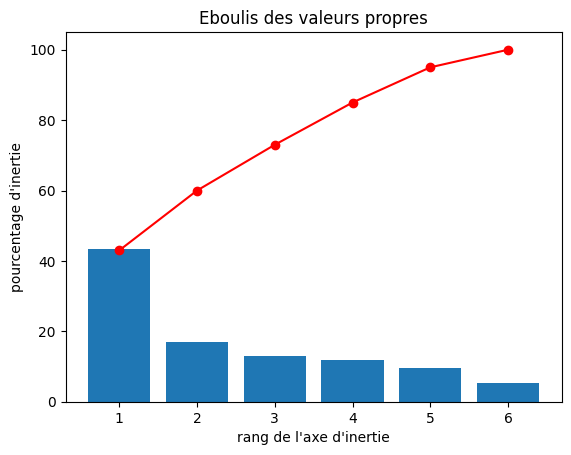

In [25]:
# 73% de l'inertie expliquée par les 3 premières composantes
# Réalisation du diagramme "éboulis des valeurs propres"

#liste de nos composantes
x_list = range(1, n_components+1)

# on affiche le graphique "éboulé des valeurs propres" et la somme cumulée des captages
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [26]:
# Je m'intéresse maintenant à la composition des composantes en fonction des variables de mon dataframe
pcs = acp.components_
pcs = pd.DataFrame(pcs)
pcs.columns = noms_colonnes
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
F1,-0.08,0.33,0.39,0.51,0.44,-0.53
F2,0.94,0.31,0.11,-0.07,-0.00,0.05
F3,-0.29,0.89,-0.16,-0.11,-0.27,0.15
F4,-0.10,-0.05,0.87,-0.09,-0.44,0.18
F5,-0.12,0.10,0.24,-0.56,0.71,0.31
F6,0.01,0.01,0.00,0.63,0.17,0.76


<AxesSubplot: >

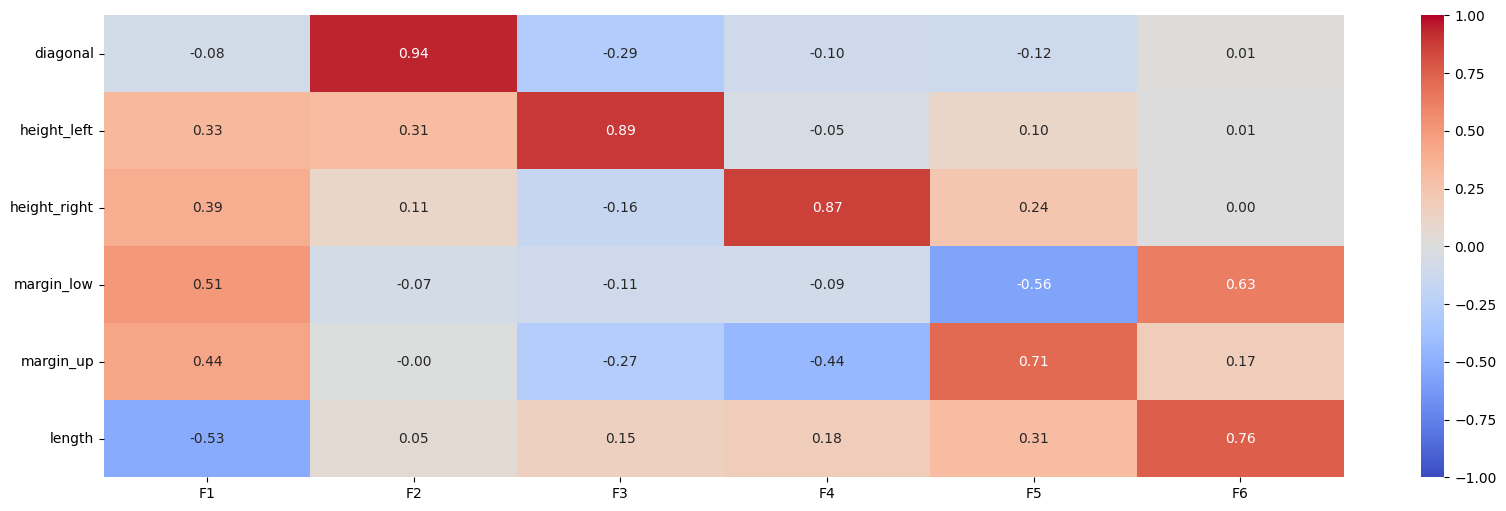

In [27]:
# Je vais représenter ces valeurs sous forme de heatmap afin de mieux voir la décomposition des composantes selon les variables
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

**F1 est très corrélé à margin_low et inversement corrélé à length**

**F2 est très fortement corrélée à la diagonale**

#### Les deux premiers axes expliquent 60% de l'inertie totale ==> 2 axes principaux: F1 et F2

In [28]:
# Cette fonction sera utilisée plus tard afin de projeter les clusters dans le plans (F1, F2)
def display_factorial_planes(   X_projected, 
                                x_y, 
                                acp=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if acp : 
        v1 = str(round(100*acp.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*acp.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :        
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

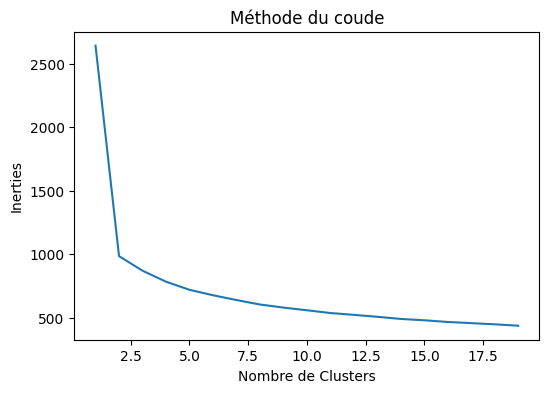

In [29]:
# Méthode du coude pour déterminer le nombre de cluster
wcss = []
mapping1 = {}
for i in range(1,20):
    km=KMeans(n_clusters=i)
    km.fit(Billet_vf)
    wcss.append(km.inertia_)
    mapping1[i] = km.inertia_
plt.figure(figsize=(6,4))
#plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(range(1,20),wcss)
plt.title('Méthode du coude')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inerties')
plt.show()

**Confirmation qu'il y a 2 clusters**

In [30]:
# Création et chargement du modèle KMEAN
km = KMeans(n_clusters=2)
km.fit(Billet_vf_acp)

#pickle.dump(km, open("km.pkl", "wb"))
clusters_km  = pickle.load(open('km.pkl', 'rb')).labels_

Billet_vf_acp['Clusterkm'] = clusters_km
Billet_vf_acp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1500 non-null   float64
 1   height_left   1500 non-null   float64
 2   height_right  1500 non-null   float64
 3   margin_low    1500 non-null   float64
 4   margin_up     1500 non-null   float64
 5   length        1500 non-null   float64
 6   Clusterkm     1500 non-null   int32  
dtypes: float64(6), int32(1)
memory usage: 87.9 KB


C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


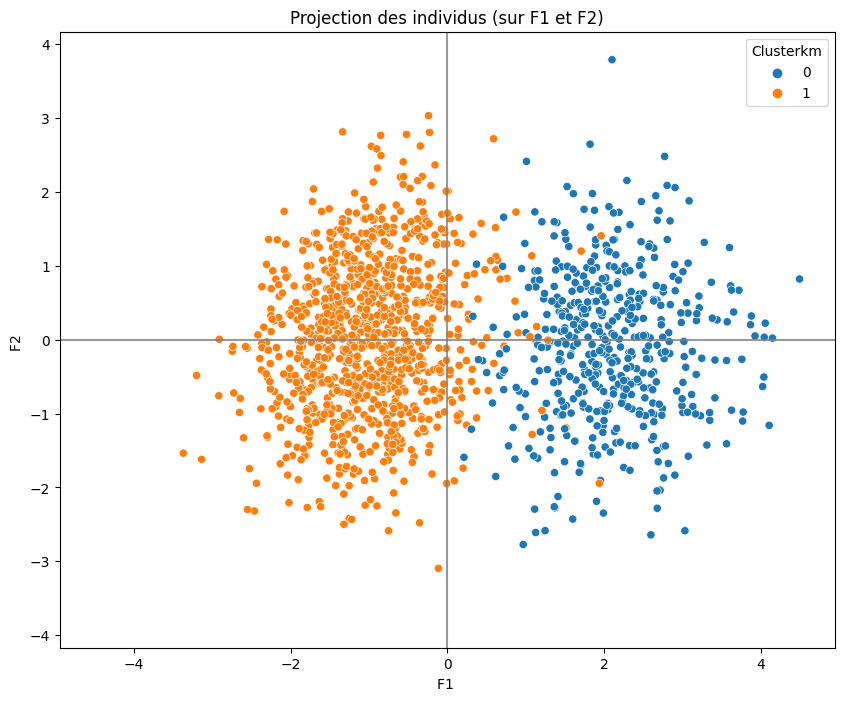

In [31]:
# Projection de mes billets sur le plan (F1, F2)
X_proj = acp.transform(X_scaled)
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=Billet_vf_acp['Clusterkm'])

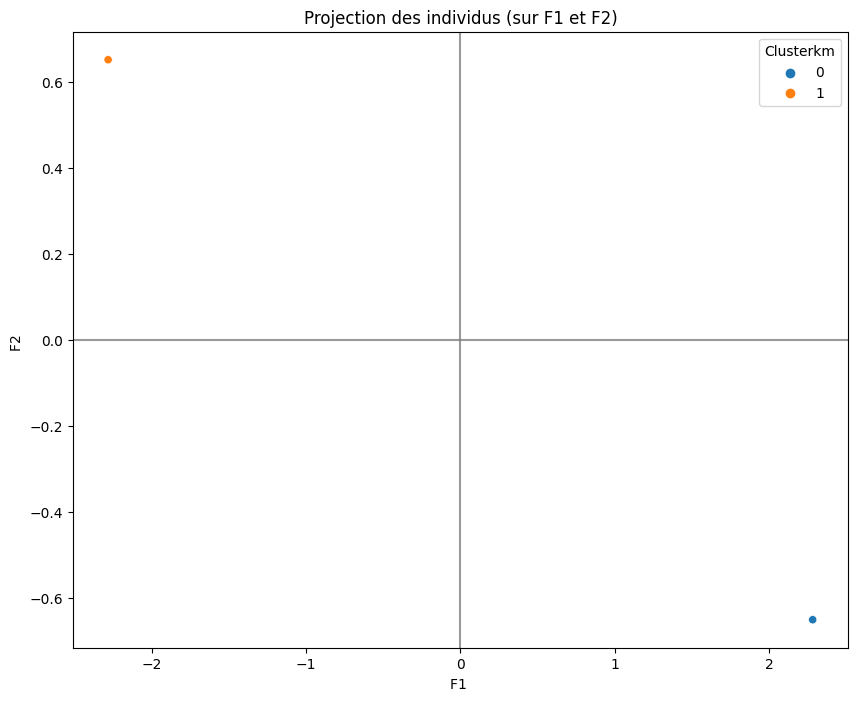

In [32]:
# Moyenne des variables non standardisées, par cluster
groupes_centroides = Billet_vf_acp.groupby(['Clusterkm']).mean().reset_index()

groupes_centroides_ACP = groupes_centroides.set_index('Clusterkm')

X = groupes_centroides_ACP.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Projection des points dans le premier plan factoriel
X_proj = acp.transform(X_scaled)
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=groupes_centroides_ACP.index)

In [33]:
# Correspondance des clusters
km_matrix = pd.crosstab(clusters_km,Billet_vf["is_genuine"])
print(km_matrix)

is_genuine  False  True 
row_0                   
0             481      3
1              19    997


**Cluster 0 : Faux billets**

**Cluster 1 : Vrais billets**

In [34]:
# Description de la classification
y_pred = pickle.load(open('km.pkl', 'rb')).predict(x_test) 
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 90,   6],
       [  0, 204]], dtype=int64)

#### Matrice de confusion

Text(0.5, 1.0, 'Matrice de confusion avec la méthode KMEAN\n')

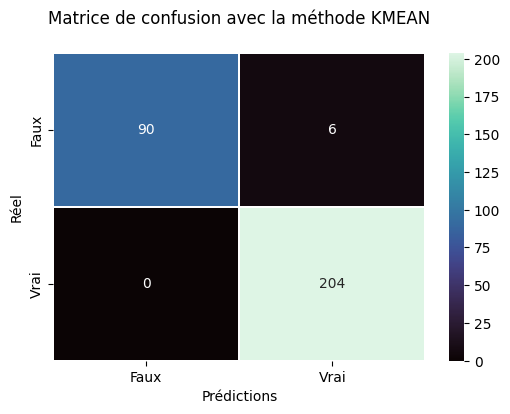

In [35]:
class_names=["Faux","Vrai"] 
plt.figure(figsize=(6,4))
tick_marks = np.arange(len(class_names))
xticklabels =["Faux","Vrai"]
yticklabels=["Faux","Vrai"]

# create heatmap
sns.heatmap(cnf_matrix,
            annot = True,
            fmt = ".3g", 
        
       cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion avec la méthode KMEAN\n")

**Interpretation de la matrice de confusion du k mean**

La matrice de confusion nous donne des informations sur la performance de prediction du modèle. Sur les 96 faux billets, 90 ont été correctement prédit(vrais négatifs) soit un taux de prediction de 93,8% pour les faux billets. les vrais positifs ou le nombre de vrais billets qui ont éte correctement classés est de 204 sur les 204 vrais billets de l'echantillon de test. le nombre de faux positif ou les vrais billets de banque qui ont été classifiés comme faux est de 0, le nombre de faux négatifs ou les faux billets de banque qui ont été classés comme vrai par le modèle est de 6

**Interpretation des autres métriques:**

In [36]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.98
Precision: 0.9714285714285714
Recall: 1.0


L'accuracy est de 98,7% c'est à dire que la capacité du modèle à faire de bonnes prédictions sur cet échantillon est de 98.5%;

La précision est de 98,07% c'est la part des enregistrements réellement positifs(vrais billets) sur les enregistrements positifs prédits;

Le Recall ou rappel est de 100%: c'est la part des vrais billets correctement predits sur le nombre total de vrais billet ou Couverture des observations vraiment positives.

Les métriques d'évaluation de notre modèle de k means sont satisfaisantes.

#### Courbe ROC

La caractéristique de performance (d'un test) ou courbe sensibilité/spécificité (appelé courbe ROC), est une mesure de la performance d'un classificateur binaire.
Graphiquement, on représente souvent la mesure ROC sous la forme d'une courbe qui donne le taux de vrais positifs en fonction du taux de faux positifs.
Un score AUC de 1 représente un classificateur parfait, un score de 0.5 représente un classificateur inutile.

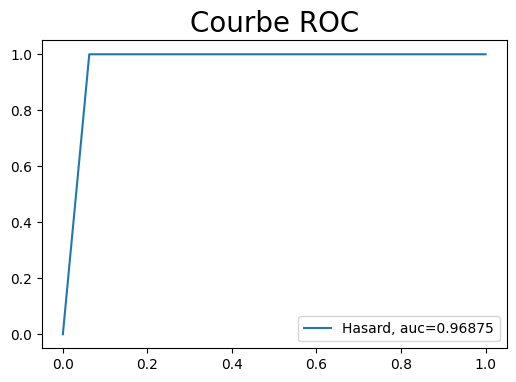

In [37]:
# Je charge mon modèle KMEAN
model = pickle.load(open('km.pkl', 'rb'))

prob = model.predict(x_test)
fper, tper, thresholds = roc_curve(y_test, prob)
auc = metrics.roc_auc_score(y_test, prob)
x = [0,1]
y = [0,1]
plt.figure(figsize=(6,4))
plt.plot(fper,tper,label="Hasard, auc="+str(auc))
plt.legend(loc=4)
plt.title('Courbe ROC', fontsize=20)
ax.set_ylabel('Taux Vraix Positifs', fontsize=14)
ax.set_xlabel('Taux Faux Positifs', fontsize=14)
plt.show()

**AUC très proche de 1 ==> modèle très bon**

### Prédiction des données et algorithme pour la méthode KMEAN

In [38]:
df_billet_test = pd.read_csv("billets_production.csv")
df_billet_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
 6   id            5 non-null      object 
dtypes: float64(6), object(1)
memory usage: 408.0+ bytes


In [39]:
df_billet_test.head(5)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [40]:
X = df_billet_test.iloc[:, :-1]
k_score=pd.Series(pickle.load(open('km.pkl', 'rb')).predict(X))

km_predict_result= pd.concat([df_billet_test, k_score], axis=1)

#Résultats de la classification prédictive :
resultat = []
for i in km_predict_result[0] == 0:
    if i is True :
        resultat.append('Faux Billet')
    else :
        resultat.append('Vrai Billet')

km_predict_result['resultat_kmean'] = resultat
km_predict_result

,diagonal,height_left,height_right,margin_low,margin_up,length,id,0,resultat_kmean
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0,Faux Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0,Faux Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0,Faux Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1,Vrai Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1,Vrai Billet


## b) Méthode Régression logistique<a class="anchor" id="section_2_2"></a>

Le principe du modèle de la régression logistique est d'expliquer la survenance ou non d'un événement, dans notre cas, faux billet ou vrai billet par le niveau de variables explicatives quantitatives (notées X). le but est de construire un algorithme de regression logistique qui permet de classifier les billets en vrai ou faux. Nous évaluerons notre modèle sur les données de test.

In [41]:
vrai_faux_billets = Billet_vf["is_genuine"]
reste_billet=Billet_vf.drop(columns=['is_genuine'], axis=1)

# Regression logistique:
reg_log = Logit(endog=vrai_faux_billets,exog=reste_billet)

# Calculs:
res_log = reg_log.fit()

# Resume des resultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.028471
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1494
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Oct 2023   Pseudo R-squ.:                  0.9553
Time:                        15:55:59   Log-Likelihood:                -42.707
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
diagonal        -0.6396      0.704     -0.909      0.363      -2.019       0.740
height_left     -2.022

La p_value est <0.05 donc le modèle est significatif dans sa globalité. il y a des variables qui ne sont pas significatives dans le modèle(la diagonale, heigth_left), je vais les retirées pour voir si le R2 est significativement différent

In [42]:
reste_reste_billet=reste_billet.drop(columns=['diagonal', "height_left"], axis=1)

# Regression logistique:
reg_log_2 = Logit(endog=vrai_faux_billets,exog=reste_reste_billet)

# Calculs:
res_log_2 = reg_log_2.fit()

# Resume des resultats:
print(res_log_2.summary())

Optimization terminated successfully.
         Current function value: 0.030986
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1496
Method:                           MLE   Df Model:                            3
Date:                Fri, 06 Oct 2023   Pseudo R-squ.:                  0.9513
Time:                        15:55:59   Log-Likelihood:                -46.478
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
height_right    -5.0148      0.680     -7.376      0.000      -6.347      -3.682
margin_low      -5.868

**Le R carré pas significativement différent sans ces variables ==> je décide de les garder dans ma future analyse**

#### Création de la matrice de confusion

In [43]:
reg_logit = linear_model.LogisticRegression()    
reg_logit.fit(x_train, y_train)  

#pickle.dump(reg_logit, open("reg_logit.pkl", "wb"))

y_pred = pickle.load(open('reg_logit.pkl', 'rb')).predict(x_test) 
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 92,   4],
       [  1, 203]], dtype=int64)

Text(0.5, 1.0, 'Matrice de confusion de la régression logistique\n')

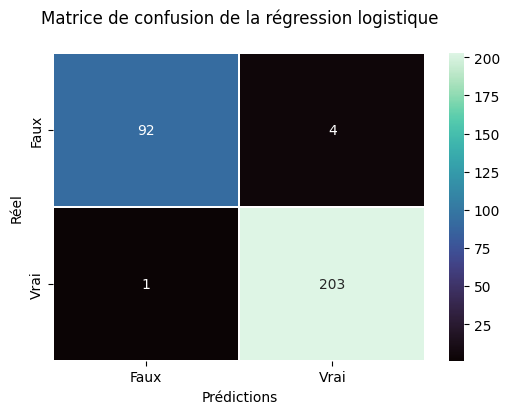

In [44]:
class_names=["Faux","Vrai"] 
plt.figure(figsize=(6,4))
tick_marks = np.arange(len(class_names))
xticklabels =["Faux","Vrai"]
yticklabels=["Faux","Vrai"]
# create heatmap
sns.heatmap(cnf_matrix,
            annot = True,
            fmt = ".3g", 
        
       cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion de la régression logistique\n")

**Interpretation de la matrice de confusion par la méthode de régression logistique**

La matrice de confusion nous donne des informations sur la performance de prediction du modèle.
Sur les 96 faux billets, 92 ont été correctement prédit(vrais négatifs) soit un taux de prediction de 95,83%.

les vrais positifs ou le nombre de vrais billets qui ont éte correctement classés est de 203 sur les 204 vrais billets de l'echantillon de test.
le nombre de faux positif ou le vrais billets de banque qui ont été classifiés comme faux est de 1
le nombre de faux négatifs ou les faux billets de banque qui ont été classés comme vrai par le modèle est de 4

**Interpretation des autres métriques:**

In [45]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9833333333333333
Precision: 0.9806763285024155
Recall: 0.9950980392156863


 L'accuracy est de 98% c'est à dire que la capacité du modèle à faire de bonnes prédictions sur cet échantillon est de 98.3%;

 La précision est de 98,08% c'est  la part des enregistrements réellement positifs(vrais billets) sur les enregistrements positifs prédits;

 Le Recall ou rappel est de 99,50%: c'est la part des vrais billets correctement predits sur le nombre total de vrais billet ou Couverture des observations vraiment positives.

 Les métriques d'évaluation de notre modèle de regression logistique sont satisfaisantes.

#### Courbe ROC

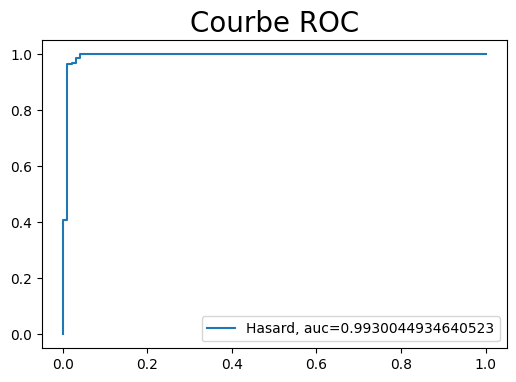

In [46]:
# Je charge mon modèle reg_logit
model = pickle.load(open('reg_logit.pkl', 'rb'))

prob = model.predict_proba(x_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
auc = metrics.roc_auc_score(y_test, prob)
x = [0,1]
y = [0,1]
plt.figure(figsize=(6,4))
plt.plot(fper,tper,label="Hasard, auc="+str(auc))
plt.legend(loc=4)
plt.title('Courbe ROC', fontsize=20)
ax.set_ylabel('Taux Vraix Positifs', fontsize=14)
ax.set_xlabel('Taux Faux Positifs', fontsize=14)
plt.show()

**Le score AUC est très proche de 1 ==> le classifficateur est donc presque parfait**

### Prédiction des données et algorithme pour la méthode régression logistique

In [47]:
X = df_billet_test.iloc[:, :-1]

#Utilisation du modèle de prédiction "regressif linéaire logistique"
probability = (pickle.load(open('reg_logit.pkl', 'rb'))).predict_proba(X.values)[:, 1]

#Probabilités des billets établies (que ce soit un vrai billet)
proba = pd.Series(probability.round(3), name='value')
proba

C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0    0.003
1    0.001
2    0.001
3    0.922
4    1.000
Name: value, dtype: float64

In [48]:
df = pd.concat([X, proba], axis=1)

#Résultats de la classification prédictive :
resultat = []
for i in df['value'] >= .5:
    if i is True :
        resultat.append('Vrai Billet')
    else :
        resultat.append('Faux Billet')

df['resultat_reg_log'] = resultat
df

,diagonal,height_left,height_right,margin_low,margin_up,length,value,resultat_reg_log
0,171.76,104.01,103.54,5.21,3.30,111.42,0.003,Faux Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,0.001,Faux Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,0.001,Faux Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,0.922,Vrai Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,1.000,Vrai Billet


**Comme précédemment, les 3 premiers billets sont faux, les deux suivants sont vrais**

## c) Méthode KNN<a class="anchor" id="section_2_3"></a>

Cette méthode n'est pas paramétrique, mais purement géométrique. En effet, elle consiste à deviner la nature d'un objet à travers ses voisins les plus proches.

C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:2

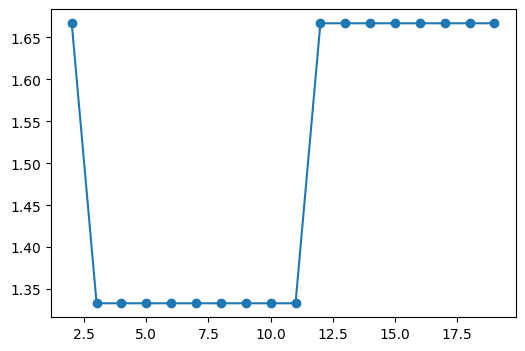

In [49]:
# Je commence par déterminer le nombre de voisins idéal afin d'obtenir le pourcentage d'erreur le plus faible possible pour mon modèle
errors = []
for k in range(2,20):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(x_train, y_train).score(x_test, y_test)))
plt.figure(figsize=(6,4))
plt.plot(range(2,20), errors, 'o-')
plt.show()

**Pour k compris entre 3 et 11, nous avons le plus faible pourcentage d'erreur ==> je choisi arbitrairement les 8 voisins les plus proches pour la prédiction**

In [50]:
# Je détermine le pourcentage d'erreur de mon modèle avec 8 voisins
knn = neighbors.KNeighborsClassifier(8)
knn.fit(x_train, y_train)

#pickle.dump(knn, open("knn.pkl", "wb"))
error = 1 - (pickle.load(open('reg_logit.pkl', 'rb'))).score(x_test, y_test)
print('Le pourcentage d erreur du modèle est : %f' % error)

C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Le pourcentage d erreur du modèle est : 0.016667


#### Matrice de confusion

In [51]:
y_pred = (pickle.load(open('knn.pkl', 'rb'))).predict(x_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 92,   4],
       [  0, 204]], dtype=int64)

Text(0.5, 1.0, 'Matrice de confusion de la régression logistique\n')

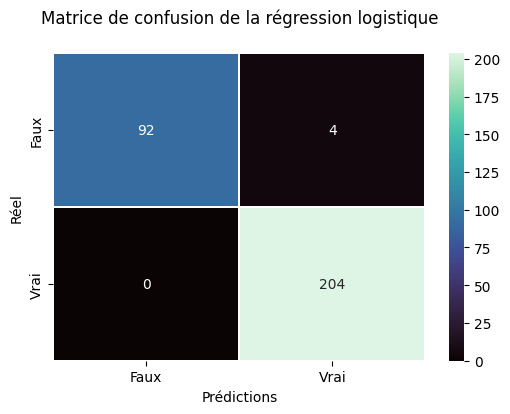

In [52]:
class_names=["Faux","Vrai"] 
plt.figure(figsize=(6,4))
tick_marks = np.arange(len(class_names))
xticklabels =["Faux","Vrai"]
yticklabels=["Faux","Vrai"]
# create heatmap
sns.heatmap(cnf_matrix,
            annot = True,
            fmt = ".3g", 
        
       cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion de la régression logistique\n")

**Interpretation de la matrice de confusion de la méthode KNN**

La matrice de confusion nous donne des informations sur la performance de prediction du modèle. Sur les 96 faux billets, 92 ont été correctement prédit(vrais négatifs) soit un taux de prediction de 93,8% pour les faux billets. les vrais positifs ou le nombre de vrais billets qui ont éte correctement classés est de 204 sur les 204 vrais billets de l'echantillon de test. le nombre de faux positif ou les vrais billets de banque qui ont été classifiés comme faux est de 0, le nombre de faux négatifs ou les faux billets de banque qui ont été classés comme vrai par le modèle est de 4

**Interpretation des autres métriques:**

In [53]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9866666666666667
Precision: 0.9807692307692307
Recall: 1.0


L'accuracy est de 98,7% c'est à dire que la capacité du modèle à faire de bonnes prédictions sur cet échantillon est de 98.3%;

La précision est de 98,07% c'est la part des enregistrements réellement positifs(vrais billets) sur les enregistrements positifs prédits;

Le Recall ou rappel est de 100%: c'est la part des vrais billets correctement predits sur le nombre total de vrais billet ou Couverture des observations vraiment positives.

Les métriques d'évaluation de notre modèle de k means sont satisfaisantes.

#### Courbe ROC

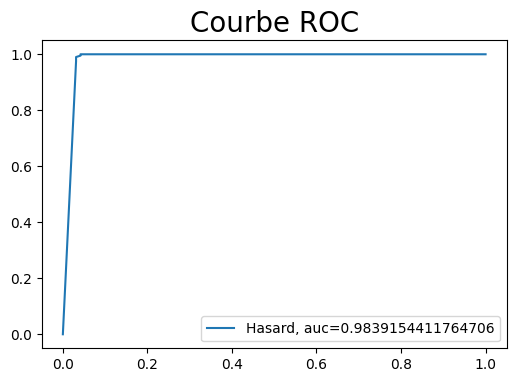

In [54]:
# Je charge mon modèle KNN
model = pickle.load(open('knn.pkl', 'rb'))

prob = model.predict_proba(x_test)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_test, prob)
auc = metrics.roc_auc_score(y_test, prob)
x = [0,1]
y = [0,1]
plt.figure(figsize=(6,4))
plt.plot(fper,tper,label="Hasard, auc="+str(auc))
plt.legend(loc=4)
plt.title('Courbe ROC', fontsize=20)
ax.set_ylabel('Taux Vraix Positifs', fontsize=14)
ax.set_xlabel('Taux Faux Positifs', fontsize=14)
plt.show()

**Le score AUC est très proche de 1 ==> le classifficateur est donc presque parfait**

### Prédiction des données et algorithme pour la méthode KNN

In [55]:
# Je récupère les billets de test
X = df_billet_test.iloc[:, :-1]

knn_score=pd.Series((pickle.load(open('knn.pkl', 'rb'))).predict(X))

knn_predict_result= pd.concat([df_billet_test, knn_score], axis=1)
#knn_predict_result
#Résultats de la classification prédictive :
resultat = []
for i in knn_predict_result[0] == False:
    if i is True :
        resultat.append('Faux Billet')
    else :
        resultat.append('Vrai Billet')

knn_predict_result['resultat_knn'] = resultat
knn_predict_result

,diagonal,height_left,height_right,margin_low,margin_up,length,id,0,resultat_knn
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,Faux Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,Faux Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,Faux Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,Vrai Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,Vrai Billet


**Comme précédemment, les 3 premiers billets sont faux, les deux suivants sont vrais**

# Conclusion générale<a class="anchor" id="conclusion"></a>

Les 3 méthodes nous donnent les mêmes résultats :
    
**Les 3 premiers billets sont faux**

**Les 2 derniers billets sont vrais**

Pour chacune de ces méthodes, les métriques sont très bonnes et leurs score AUC est très bon.

Ce qui va me permettre de privilégier une méthode plutôt qu'une autre est l'utilité des informations supplémentaires récupérés avec la classification.

De ce point de vue, **la méthode par régression logistique** est la plus utile : nous obtenons en plus de la classification un pourcentage d'exactitude sur celle-ci.

Je vais donc , pour terminer, créer un algorithme afin de généraliser cette méthode à tout nouveau document (concernant les billets il va s'en dire).

# Evaluation :  algorithme généralisé pour le modèle "régression logistique"<a class="anchor" id="evaluation"></a>

In [56]:
# Je récupère les billets du nouveau document
df_billet_test = pd.read_csv("billets_test (5).csv")
X = df_billet_test.iloc[:, :-1]

#Utilisation du modèle de prédiction "regressif linéaire logistique"
probability = (pickle.load(open('reg_logit.pkl', 'rb'))).predict_proba(X.values)[:, 1]

#Probabilités des billets établies (que ce soit un vrai billet)
proba = pd.Series(probability.round(3), name='probabilité')

df = pd.concat([X, proba], axis=1)

#Résultats de la classification prédictive :
resultat = []
for i in df['probabilité'] >= .5:
    if i is True :
        resultat.append('Vrai Billet')
    else :
        resultat.append('Faux Billet')

df['resultat_reg_log'] = resultat
df

C:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,diagonal,height_left,height_right,margin_low,margin_up,length,probabilité,resultat_reg_log
0,172.09,103.95,103.73,4.39,3.09,113.19,0.991,Vrai Billet
1,171.52,104.17,104.03,5.27,3.16,111.82,0.007,Faux Billet
2,171.78,103.80,103.75,3.81,3.24,113.39,1.000,Vrai Billet
3,172.02,104.08,103.99,5.57,3.30,111.10,0.000,Faux Billet
4,171.79,104.34,104.37,5.00,3.07,111.87,0.010,Faux Billet
